# Imports

In [3]:
import os
import shutil
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras.models import load_model
import numpy as np
import random
from sklearn.model_selection import KFold

# Mount to google drive

In [4]:
from google.colab import drive

drive.mount("/content/drive/")

Mounted at /content/drive/


# Show some images of our dataset

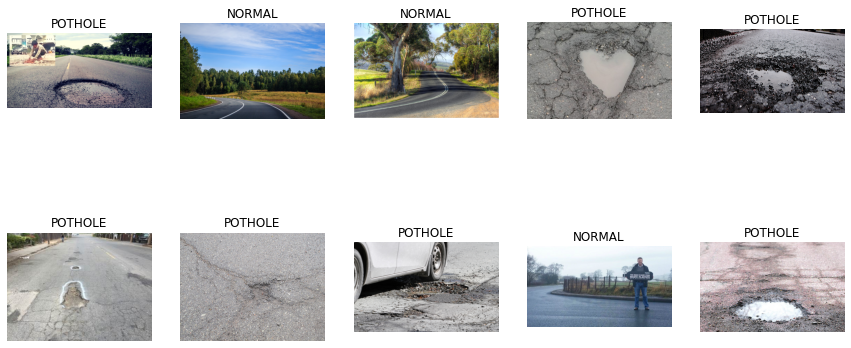

In [ ]:
import random as rn
import os
from matplotlib import pyplot as plt
from matplotlib import image as plot_image

dataset = []
datasetDir = []
numImages = 0
imageSize = 100

for directory, folders, images in os.walk('/content/drive/My Drive/Colab/AIProject/KCrossFoldFolder/training_set'):
  for image in images:
    numImages += 1
    dataset.append(os.path.join(directory, image))
    datasetDir.append(directory)

fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(15,15)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,numImages)
        ax[i,j].imshow(plot_image.imread(dataset[l]))
        ax[i,j].set_aspect('equal')
        ax[i,j].axis('off')
        

        if (datasetDir[l].endswith('normal')):
          ax[i,j].set_title("NORMAL")
        else:
          ax[i,j].set_title("POTHOLE")

# Establish Our Training Array + Functions for K Cross Fold Validation

In [ ]:
def EstablishTrainFolderArray(dir, sourceFolder):

  trainFolder = os.path.join(dir, sourceFolder)
  trainArray = []
  trainLabelArray = []

  for directory, folders, images in os.walk(trainFolder):
    for image in images:
      trainArray.append(image)
      trainLabelArray.append(directory)

  # Shuffle both lists randomly but in sync
  temp = list(zip(trainArray, trainLabelArray))
  random.shuffle(temp)
  trainArray, trainLabelArray = zip(*temp)
      
  return trainArray, trainLabelArray
  

def TransferAllFiles(dir, sourceFolder, destFolder, potholeLabel, normalLabel):
  #print("Initiating all file transfer from: " + str(sourceFolder) + " to " + str(destFolder))

  fullSourcePath = os.path.join(dir, sourceFolder)
  fullDestPath = os.path.join(dir, destFolder)

  sourceNormalsPath = os.path.join(fullSourcePath, normalLabel)
  sourcePotholesPath = os.path.join(fullSourcePath, potholeLabel)
  destNormalsPath = os.path.join(fullDestPath, normalLabel)
  destPotholesPath = os.path.join(fullDestPath, potholeLabel)

  # print("Num of files in source:" + str(len(os.listdir(fullSourcePath))))

  for directory, folder, images in os.walk(fullSourcePath):
    for imageName in images:
      if (directory.endswith(potholeLabel)):
        #print("Moving file: " + str(os.path.join(sourcePotholesPath, imageName)) + " to destination folder: " + str(destPotholesPath))
        shutil.move(os.path.join(sourcePotholesPath, imageName), destPotholesPath)
      else:
        shutil.move(os.path.join(sourceNormalsPath, imageName), destNormalsPath)

def TransferFiles(dir, sourceFolder, destFolder, indexArray, establishedArray, establishedLabelArray, potholeLabel, normalLabel):
  
  fullSourcePath = os.path.join(dir, sourceFolder)
  fullDestPath = os.path.join(dir, destFolder)

  sourceNormalsPath = os.path.join(fullSourcePath, normalLabel)
  sourcePotholesPath = os.path.join(fullSourcePath, potholeLabel)
  destNormalsPath = os.path.join(fullDestPath, normalLabel)
  destPotholesPath = os.path.join(fullDestPath, potholeLabel)

  sourceFilesList = os.listdir(fullSourcePath)


  print()

  for i in indexArray:
    #print("For index: "+ str(i)) #print("We would move in the established array file: "+ establishedArray[i]) #print("The directory for this file found in our label array is: " + establishedLabelArray[i])

    if (establishedLabelArray[i].endswith(pothole_label)):
      #print("This one ends with pothole, so we would move it to:" + str(destPotholesPath))
      shutil.move(os.path.join(sourcePotholesPath, establishedArray[i]), destPotholesPath)
    else:
      #print("This is not a pothole, and would move this file to: " + str(destNormalsPath))
      shutil.move(os.path.join(sourceNormalsPath, establishedArray[i]), destNormalsPath)



directory = "/content/drive/My Drive/Colab/AIProject/KCrossFoldFolder"
training_folder = 'training_set'
validation_folder = 'val_set'
pothole_label = 'potholes'
normal_label = 'normal'

# Make sure all images are currently in the training folder
TransferAllFiles(directory, validation_folder, training_folder, pothole_label, normal_label)

# Establishing our train array immediately. Array is used for our K Cross fold so that we have consistest indexing
trainArray, trainLabelArray = EstablishTrainFolderArray(directory, training_folder)

# Model(s) Generation

In [ ]:
def get2VGGblockModel():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(imageSize, imageSize, 1)))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Dropout(0.3))

  model.add(Flatten())

  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model

# Model Summary

In [ ]:
model = get2VGGblockModel()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        1

# Callback Methods



In [ ]:
def get_model_name(k):
    return '/model_'+str(k)+'.h5'

# Training + Evaluation Functions

In [8]:
def trainModel(model, name, training, val, epochs, checkpoints):
  print("-------------Model: " + name)


  steps = np.ceil(training.samples // training.batch_size)
  val_steps = np.ceil(val.samples // val.batch_size)

  history = model.fit(training, 
                    steps_per_epoch = steps, 
                    epochs = epochs,
                    validation_data = val,
                    validation_steps = val_steps,
                    verbose = 1,
                    callbacks=checkpoints
                    )

  return history

def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.ylabel('Binary Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	plt.ylim([0.0, 1.0])
	# plot accuracy
	plt.subplot(212)
	plt.ylabel('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.ylim([0.35, 1.0])
	# save plot to file
	#filename = sys.argv[0].split('/')[-1]
	#pyplot.savefig(filename + '_plot.png')
	plt.show()
	plt.close()
 
def evalModel(model, test_set):
  _, acc = model.evaluate(test_set, verbose=1)
  print('> %.3f' % (acc * 100.0))
  return acc

# Model Training


Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Greyscale Normal Training
Epoch 1/150
14/14 [==============================] - 298s 21s/step - loss: 0.9172 - accuracy: 0.6176 - val_loss: 2.1571 - val_accuracy: 0.5938

Epoch 00001: val_accuracy improved from -inf to 0.59375, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels/model_1.h5
Epoch 2/150
14/14 [==============================] - 13s 905ms/step - loss: 0.5355 - accuracy: 0.7499 - val_loss: 1.2395 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.59375
Epoch 3/150
14/14 [==============================] - 13s 951ms/step - loss: 0.4889 - accuracy: 0.7769 - val_loss: 0.8371 - val_accuracy: 0.5625

Epoch 00003: val_accuracy did not improve from 0.59375
Epoch 4/150
14/14 [==============================] - 13s 942ms/step - loss: 0.5063 - accuracy: 0.7567 - val_loss: 0.9908 - val_accura

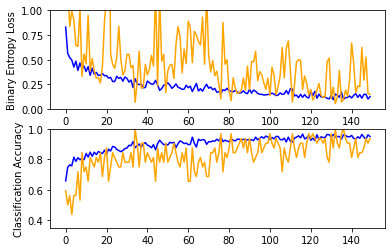

5/5 [==============================] - 80s 20s/step - loss: 0.5019 - accuracy: 0.8742
> 87.417

Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Greyscale Normal Training
Epoch 1/150
14/14 [==============================] - 15s 1s/step - loss: 0.8817 - accuracy: 0.5936 - val_loss: 1.8274 - val_accuracy: 0.4062

Epoch 00001: val_accuracy improved from -inf to 0.40625, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels/model_2.h5
Epoch 2/150
14/14 [==============================] - 13s 984ms/step - loss: 0.6247 - accuracy: 0.6969 - val_loss: 0.7232 - val_accuracy: 0.5625

Epoch 00002: val_accuracy improved from 0.40625 to 0.56250, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels/model_2.h5
Epoch 3/150
14/14 [==============================] - 14s 1s/step - loss: 0.5588 - accuracy: 0.7845 - val_loss: 0.6519 - val_accuracy: 0.65

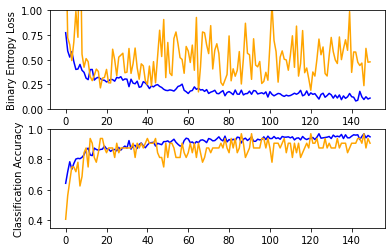

5/5 [==============================] - 3s 601ms/step - loss: 0.4235 - accuracy: 0.8808
> 88.079

Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Greyscale Normal Training
Epoch 1/150
14/14 [==============================] - 15s 993ms/step - loss: 1.0649 - accuracy: 0.6019 - val_loss: 1.0989 - val_accuracy: 0.5625

Epoch 00001: val_accuracy improved from -inf to 0.56250, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels/model_3.h5
Epoch 2/150
14/14 [==============================] - 13s 957ms/step - loss: 0.6836 - accuracy: 0.7085 - val_loss: 0.4635 - val_accuracy: 0.8125

Epoch 00002: val_accuracy improved from 0.56250 to 0.81250, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels/model_3.h5
Epoch 3/150
14/14 [==============================] - 12s 828ms/step - loss: 0.5533 - accuracy: 0.7659 - val_loss: 0.9296 - val_accurac

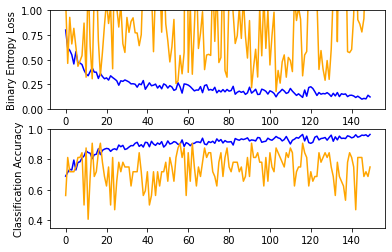

5/5 [==============================] - 3s 662ms/step - loss: 1.2966 - accuracy: 0.7947
> 79.470

Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Greyscale Normal Training
Epoch 1/150
14/14 [==============================] - 14s 941ms/step - loss: 1.1325 - accuracy: 0.5971 - val_loss: 0.7148 - val_accuracy: 0.5312

Epoch 00001: val_accuracy improved from -inf to 0.53125, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels/model_4.h5
Epoch 2/150
14/14 [==============================] - 13s 931ms/step - loss: 0.7470 - accuracy: 0.6719 - val_loss: 1.2130 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.53125
Epoch 3/150
14/14 [==============================] - 13s 918ms/step - loss: 0.5167 - accuracy: 0.7419 - val_loss: 2.3448 - val_accuracy: 0.4375

Epoch 00003: val_accuracy did not improve from 0.53125
Epoch 4/150
14/14 [=================

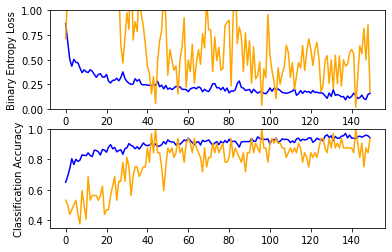

5/5 [==============================] - 3s 700ms/step - loss: 0.3857 - accuracy: 0.8940
> 89.404

Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Greyscale Normal Training
Epoch 1/150
14/14 [==============================] - 15s 1s/step - loss: 0.8436 - accuracy: 0.6237 - val_loss: 0.8153 - val_accuracy: 0.5312

Epoch 00001: val_accuracy improved from -inf to 0.53125, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels/model_5.h5
Epoch 2/150
14/14 [==============================] - 13s 914ms/step - loss: 0.5230 - accuracy: 0.7619 - val_loss: 1.0646 - val_accuracy: 0.5625

Epoch 00002: val_accuracy improved from 0.53125 to 0.56250, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels/model_5.h5
Epoch 3/150
14/14 [==============================] - 13s 961ms/step - loss: 0.5224 - accuracy: 0.7275 - val_loss: 0.8800 - val_accuracy: 

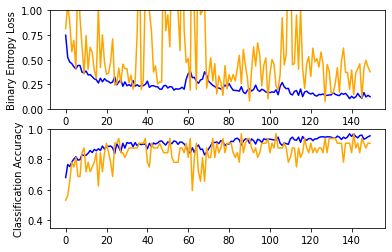

5/5 [==============================] - 3s 652ms/step - loss: 0.3660 - accuracy: 0.8940
> 89.404

Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Greyscale Normal Training
Epoch 1/150
14/14 [==============================] - 14s 1s/step - loss: 0.9144 - accuracy: 0.6535 - val_loss: 1.2689 - val_accuracy: 0.5312

Epoch 00001: val_accuracy improved from -inf to 0.53125, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels/model_6.h5
Epoch 2/150
14/14 [==============================] - 13s 885ms/step - loss: 0.5035 - accuracy: 0.7458 - val_loss: 1.3639 - val_accuracy: 0.5312

Epoch 00002: val_accuracy did not improve from 0.53125
Epoch 3/150
14/14 [==============================] - 12s 903ms/step - loss: 0.4719 - accuracy: 0.7913 - val_loss: 1.7723 - val_accuracy: 0.5625

Epoch 00003: val_accuracy improved from 0.53125 to 0.56250, saving model to /content/drive/My 

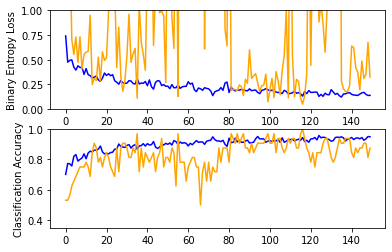

5/5 [==============================] - 3s 663ms/step - loss: 0.6352 - accuracy: 0.8411
> 84.106

Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Greyscale Normal Training
Epoch 1/150
14/14 [==============================] - 15s 931ms/step - loss: 0.9232 - accuracy: 0.5895 - val_loss: 1.1773 - val_accuracy: 0.3438

Epoch 00001: val_accuracy improved from -inf to 0.34375, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels/model_7.h5
Epoch 2/150
14/14 [==============================] - 12s 924ms/step - loss: 0.6059 - accuracy: 0.6738 - val_loss: 1.2080 - val_accuracy: 0.5938

Epoch 00002: val_accuracy improved from 0.34375 to 0.59375, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels/model_7.h5
Epoch 3/150
14/14 [==============================] - 13s 947ms/step - loss: 0.5039 - accuracy: 0.7420 - val_loss: 1.5457 - val_accurac

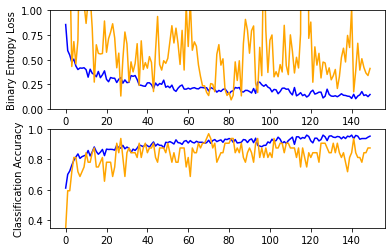

5/5 [==============================] - 3s 636ms/step - loss: 0.9053 - accuracy: 0.8278
> 82.781

Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Greyscale Normal Training
Epoch 1/150
14/14 [==============================] - 14s 957ms/step - loss: 0.8298 - accuracy: 0.6270 - val_loss: 2.5989 - val_accuracy: 0.6250

Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels/model_8.h5
Epoch 2/150
14/14 [==============================] - 13s 911ms/step - loss: 0.5338 - accuracy: 0.7233 - val_loss: 2.9054 - val_accuracy: 0.6562

Epoch 00002: val_accuracy improved from 0.62500 to 0.65625, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels/model_8.h5
Epoch 3/150
14/14 [==============================] - 12s 888ms/step - loss: 0.4840 - accuracy: 0.7798 - val_loss: 1.3371 - val_accurac

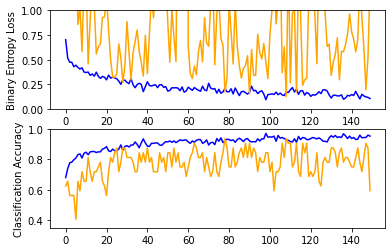

5/5 [==============================] - 3s 704ms/step - loss: 0.9467 - accuracy: 0.7020
> 70.199

Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Greyscale Normal Training
Epoch 1/150
14/14 [==============================] - 15s 1s/step - loss: 0.9437 - accuracy: 0.6225 - val_loss: 2.4376 - val_accuracy: 0.4688

Epoch 00001: val_accuracy improved from -inf to 0.46875, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels/model_9.h5
Epoch 2/150
14/14 [==============================] - 13s 963ms/step - loss: 0.6321 - accuracy: 0.7196 - val_loss: 2.6581 - val_accuracy: 0.5938

Epoch 00002: val_accuracy improved from 0.46875 to 0.59375, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels/model_9.h5
Epoch 3/150
14/14 [==============================] - 13s 922ms/step - loss: 0.5503 - accuracy: 0.7373 - val_loss: 1.3897 - val_accuracy: 

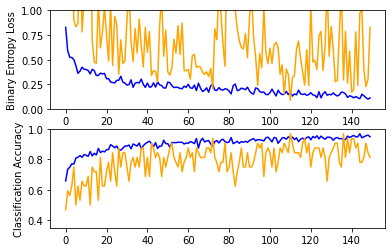

5/5 [==============================] - 3s 613ms/step - loss: 0.7895 - accuracy: 0.7881
> 78.808

Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Greyscale Normal Training
Epoch 1/150
14/14 [==============================] - 15s 998ms/step - loss: 0.8723 - accuracy: 0.6457 - val_loss: 2.9016 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels/model_10.h5
Epoch 2/150
14/14 [==============================] - 13s 897ms/step - loss: 0.6155 - accuracy: 0.7401 - val_loss: 3.4609 - val_accuracy: 0.5312

Epoch 00002: val_accuracy improved from 0.50000 to 0.53125, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels/model_10.h5
Epoch 3/150
14/14 [==============================] - 12s 910ms/step - loss: 0.5247 - accuracy: 0.7765 - val_loss: 3.9445 - val_accur

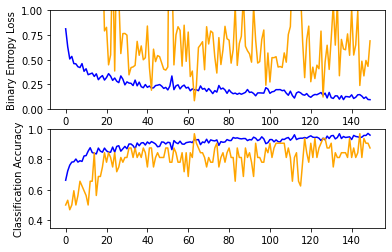

5/5 [==============================] - 3s 721ms/step - loss: 0.6373 - accuracy: 0.8344
> 83.444


In [ ]:
epochs = 150
numOfSplits = 10
kf = KFold(n_splits=numOfSplits)
accuracy = []

fold_no = 0

# this is breaking up our training array instead of our actual data, we calculate indexes ourselves through the transfer file functions
for train_index, val_index in kf.split(trainArray):
  fold_no += 1

  # Make sure that all images are back in the training folder before we start our next fold
  TransferAllFiles(directory, validation_folder, training_folder, pothole_label, normal_label)

  TransferFiles(directory, training_folder, validation_folder, val_index, trainArray, trainLabelArray, pothole_label, normal_label)

  ######################## Image Data Generator ################################
  size = 100
  batchSize = 32

  train_datagen = ImageDataGenerator(
        rescale=1./255,
        
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        rotation_range=45
        )

  test_datagen = ImageDataGenerator(
        rescale=1./255)

  training_set = train_datagen.flow_from_directory('/content/drive/My Drive/Colab/AIProject/KCrossFoldFolder/training_set',
                                                  target_size=(imageSize,imageSize),
                                                  batch_size=batchSize,
                                                  shuffle = True,
                                                  color_mode='grayscale',
                                                  class_mode='binary')

  val_set = test_datagen.flow_from_directory('/content/drive/My Drive/Colab/AIProject/KCrossFoldFolder/val_set',
                                              target_size=(imageSize,imageSize),
                                              batch_size=batchSize,
                                              shuffle = True,
                                              color_mode='grayscale',
                                              class_mode='binary')

  test_set = test_datagen.flow_from_directory('/content/drive/My Drive/Colab/AIProject/KCrossFoldFolder/test_set',
                                              target_size=(imageSize,imageSize),
                                              batch_size=batchSize,
                                              shuffle = True,
                                              color_mode='grayscale',
                                              class_mode='binary')
  
  ##############################################################################

  ############################ CHECK POINTS ####################################

  checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join("/content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels"+get_model_name(fold_no)), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')

  callbacks_list = [checkpoint]

  ##############################################################################

  ############################ MODEL TRAINING ##################################

  model = get2VGGblockModel()
  history = trainModel(model, "Greyscale Normal Training", training_set, val_set, epochs, callbacks_list)
  summarize_diagnostics(history)

  ##############################################################################

  accuracy.append(evalModel(model, test_set))

  tf.keras.backend.clear_session()
  TransferAllFiles(directory, validation_folder, training_folder, pothole_label, normal_label)

# Results

In [10]:
def FindAverageOfList(list):
  sum = 0
  for i in list:
    sum += i
  return sum / len(list)
    
for i in accuracy:
  print(i)

print("The average of this list is: " + str(FindAverageOfList(accuracy)))
print("The standard deviation of this list is: " + str(np.std(accuracy)))

NameError: ignored

# Read In Nova Scotia Images + Determine Accuracy

In [13]:
nsAccuracy = []
modelsPath = '/content/drive/My Drive/Colab/AIProject/SavedModels/NormalSavedModels'

test_datagen = ImageDataGenerator(
        rescale=1./255)
  
ns_set = test_datagen.flow_from_directory('/content/drive/My Drive/Colab/AIProject/NovaScotiaImages/NormalImages',
                                              target_size=(imageSize,imageSize),
                                              batch_size=batchSize,
                                              shuffle = True,
                                              color_mode='grayscale',
                                              class_mode='binary')
  



for i in range(1, numOfSplits+1):
  model = load_model(os.path.join(modelsPath, str("model_" + str(i) +".h5")))
  nsAccuracy.append(evalModel(model, ns_set))

print("The average accuracy on our Nova Scotia images is: " + str(FindAverageOfList(nsAccuracy)))
print("The standard deviation of our accuracy on Nova Scotia images is: " + str(np.std(nsAccuracy)))
  


Found 17 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step - loss: 0.2851 - accuracy: 0.8824
> 88.235
1/1 [==============================] - 2s 2s/step - loss: 0.6619 - accuracy: 0.8824
> 88.235
1/1 [==============================] - 2s 2s/step - loss: 0.1988 - accuracy: 0.8824
> 88.235
1/1 [==============================] - 3s 3s/step - loss: 0.3462 - accuracy: 0.8824
> 88.235
1/1 [==============================] - 3s 3s/step - loss: 0.4978 - accuracy: 0.8824
> 88.235
1/1 [==============================] - 2s 2s/step - loss: 0.4535 - accuracy: 0.8235
> 82.353
1/1 [==============================] - 2s 2s/step - loss: 0.4571 - accuracy: 0.8824
> 88.235
1/1 [==============================] - 3s 3s/step - loss: 0.4898 - accuracy: 0.8824
> 88.235
1/1 [==============================] - 2s 2s/step - loss: 0.4555 - accuracy: 0.8824
> 88.235
1/1 [==============================] - 2s 2s/step - loss: 0.4747 - accuracy: 0.8235
> 82.353
The average accuracy on our No

# AUGMENTED BEGINS HERE

# Show our dataset

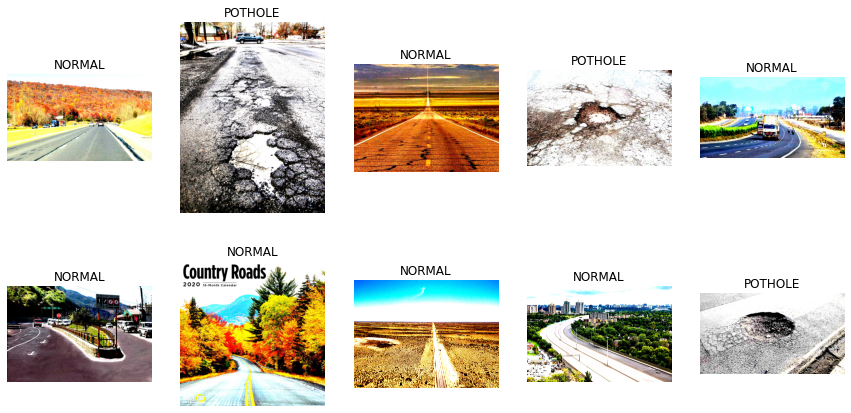

In [40]:
dataset = []
datasetDir = []
numImages = 0
imageSize = 100

for directory, folders, images in os.walk('/content/drive/My Drive/Colab/AIProject/KCrossFoldFolder/augmented_training_set'):
  for image in images:
    numImages += 1
    dataset.append(os.path.join(directory, image))
    datasetDir.append(directory)

fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(15,15)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,numImages)
        ax[i,j].imshow(plot_image.imread(dataset[l]))
        ax[i,j].set_aspect('equal')
        ax[i,j].axis('off')
        

        if (datasetDir[l].endswith('normal')):
          ax[i,j].set_title("NORMAL")
        else:
          ax[i,j].set_title("POTHOLE")

# Establish New Train Array and Paths

In [41]:
def EstablishTrainFolderArray(dir, sourceFolder):

  trainFolder = os.path.join(dir, sourceFolder)
  trainArray = []
  trainLabelArray = []

  for directory, folders, images in os.walk(trainFolder):
    for image in images:
      trainArray.append(image)
      trainLabelArray.append(directory)

  # Shuffle both lists randomly but in sync
  temp = list(zip(trainArray, trainLabelArray))
  random.shuffle(temp)
  trainArray, trainLabelArray = zip(*temp)
      
  return trainArray, trainLabelArray
  

def TransferAllFiles(dir, sourceFolder, destFolder, potholeLabel, normalLabel):
  #print("Initiating all file transfer from: " + str(sourceFolder) + " to " + str(destFolder))

  fullSourcePath = os.path.join(dir, sourceFolder)
  fullDestPath = os.path.join(dir, destFolder)

  sourceNormalsPath = os.path.join(fullSourcePath, normalLabel)
  sourcePotholesPath = os.path.join(fullSourcePath, potholeLabel)
  destNormalsPath = os.path.join(fullDestPath, normalLabel)
  destPotholesPath = os.path.join(fullDestPath, potholeLabel)

  # print("Num of files in source:" + str(len(os.listdir(fullSourcePath))))

  for directory, folder, images in os.walk(fullSourcePath):
    for imageName in images:
      if (directory.endswith(potholeLabel)):
        #print("Moving file: " + str(os.path.join(sourcePotholesPath, imageName)) + " to destination folder: " + str(destPotholesPath))
        shutil.move(os.path.join(sourcePotholesPath, imageName), destPotholesPath)
      else:
        shutil.move(os.path.join(sourceNormalsPath, imageName), destNormalsPath)

def TransferFiles(dir, sourceFolder, destFolder, indexArray, establishedArray, establishedLabelArray, potholeLabel, normalLabel):
  
  fullSourcePath = os.path.join(dir, sourceFolder)
  fullDestPath = os.path.join(dir, destFolder)

  sourceNormalsPath = os.path.join(fullSourcePath, normalLabel)
  sourcePotholesPath = os.path.join(fullSourcePath, potholeLabel)
  destNormalsPath = os.path.join(fullDestPath, normalLabel)
  destPotholesPath = os.path.join(fullDestPath, potholeLabel)

  sourceFilesList = os.listdir(fullSourcePath)


  print()

  for i in indexArray:
    #print("For index: "+ str(i)) #print("We would move in the established array file: "+ establishedArray[i]) #print("The directory for this file found in our label array is: " + establishedLabelArray[i])

    if (establishedLabelArray[i].endswith(pothole_label)):
      #print("This one ends with pothole, so we would move it to:" + str(destPotholesPath))
      shutil.move(os.path.join(sourcePotholesPath, establishedArray[i]), destPotholesPath)
    else:
      #print("This is not a pothole, and would move this file to: " + str(destNormalsPath))
      shutil.move(os.path.join(sourceNormalsPath, establishedArray[i]), destNormalsPath)



directory = "/content/drive/My Drive/Colab/AIProject/KCrossFoldFolder"
training_folder = 'augmented_training_set'
validation_folder = 'augmented_val_set'
pothole_label = 'potholes'
normal_label = 'normal'

# Make sure all images are currently in the training folder
TransferAllFiles(directory, validation_folder, training_folder, pothole_label, normal_label)

# Establishing our train array immediately. Array is used for our K Cross fold so that we have consistest indexing
trainArray, trainLabelArray = EstablishTrainFolderArray(directory, training_folder)

# Augmented Model Generation

In [42]:
def get2VGGblockModel():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(imageSize, imageSize, 3)))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Dropout(0.3))

  model.add(Flatten())

  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model

# Augmented Model Training


Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Color Augmented Training
Epoch 1/150
14/14 [==============================] - 261s 19s/step - loss: 0.6613 - accuracy: 0.6809 - val_loss: 2.5372 - val_accuracy: 0.5938

Epoch 00001: val_accuracy improved from -inf to 0.59375, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/AugmentedSavedModels/model_1.h5
Epoch 2/150
14/14 [==============================] - 18s 1s/step - loss: 0.2979 - accuracy: 0.8793 - val_loss: 0.5403 - val_accuracy: 0.8438

Epoch 00002: val_accuracy improved from 0.59375 to 0.84375, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/AugmentedSavedModels/model_1.h5
Epoch 3/150
14/14 [==============================] - 18s 1s/step - loss: 0.3129 - accuracy: 0.9154 - val_loss: 1.0235 - val_accuracy: 0.8125

Epoch 00003: val_accuracy did not improve from 0.84375
Epoch 4/150
14/14 [=============

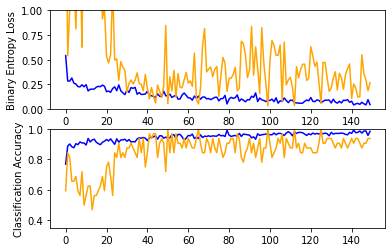

5/5 [==============================] - 73s 18s/step - loss: 0.3153 - accuracy: 0.9139
> 91.391

Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Color Augmented Training
Epoch 1/150
14/14 [==============================] - 20s 1s/step - loss: 0.8121 - accuracy: 0.6823 - val_loss: 7.8373 - val_accuracy: 0.3125

Epoch 00001: val_accuracy improved from -inf to 0.31250, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/AugmentedSavedModels/model_2.h5
Epoch 2/150
14/14 [==============================] - 18s 1s/step - loss: 0.4142 - accuracy: 0.8587 - val_loss: 6.7883 - val_accuracy: 0.5312

Epoch 00002: val_accuracy improved from 0.31250 to 0.53125, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/AugmentedSavedModels/model_2.h5
Epoch 3/150
14/14 [==============================] - 17s 1s/step - loss: 0.3113 - accuracy: 0.8862 - val_loss: 3.2780 - val_accuracy: 0.

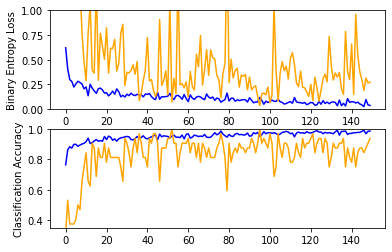

5/5 [==============================] - 5s 972ms/step - loss: 0.4262 - accuracy: 0.9272
> 92.715

Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Color Augmented Training
Epoch 1/150
14/14 [==============================] - 19s 1s/step - loss: 0.5978 - accuracy: 0.7150 - val_loss: 1.5839 - val_accuracy: 0.4688

Epoch 00001: val_accuracy improved from -inf to 0.46875, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/AugmentedSavedModels/model_3.h5
Epoch 2/150
14/14 [==============================] - 19s 1s/step - loss: 0.3684 - accuracy: 0.8431 - val_loss: 1.3788 - val_accuracy: 0.6250

Epoch 00002: val_accuracy improved from 0.46875 to 0.62500, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/AugmentedSavedModels/model_3.h5
Epoch 3/150
14/14 [==============================] - 19s 1s/step - loss: 0.3174 - accuracy: 0.8803 - val_loss: 0.5775 - val_accuracy: 0

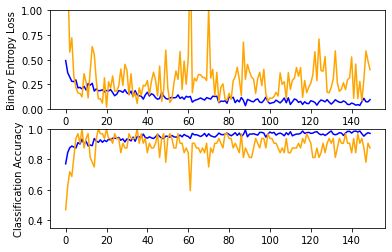

5/5 [==============================] - 5s 933ms/step - loss: 0.4387 - accuracy: 0.8543
> 85.430

Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Color Augmented Training
Epoch 1/150
14/14 [==============================] - 21s 1s/step - loss: 0.7777 - accuracy: 0.6763 - val_loss: 4.8730 - val_accuracy: 0.6250

Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/AugmentedSavedModels/model_4.h5
Epoch 2/150
14/14 [==============================] - 17s 1s/step - loss: 0.3290 - accuracy: 0.8676 - val_loss: 3.6413 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.62500
Epoch 3/150
14/14 [==============================] - 18s 1s/step - loss: 0.4266 - accuracy: 0.8411 - val_loss: 2.0350 - val_accuracy: 0.4375

Epoch 00003: val_accuracy did not improve from 0.62500
Epoch 4/150
14/14 [========================

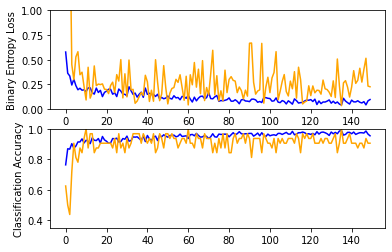

5/5 [==============================] - 5s 1s/step - loss: 0.2759 - accuracy: 0.9205
> 92.053

Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Color Augmented Training
Epoch 1/150
14/14 [==============================] - 22s 1s/step - loss: 0.6870 - accuracy: 0.6928 - val_loss: 7.8519 - val_accuracy: 0.4062

Epoch 00001: val_accuracy improved from -inf to 0.40625, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/AugmentedSavedModels/model_5.h5
Epoch 2/150
14/14 [==============================] - 20s 1s/step - loss: 0.4291 - accuracy: 0.7988 - val_loss: 2.0940 - val_accuracy: 0.5000

Epoch 00002: val_accuracy improved from 0.40625 to 0.50000, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/AugmentedSavedModels/model_5.h5
Epoch 3/150
14/14 [==============================] - 20s 1s/step - loss: 0.4299 - accuracy: 0.8186 - val_loss: 0.8105 - val_accuracy: 0.62

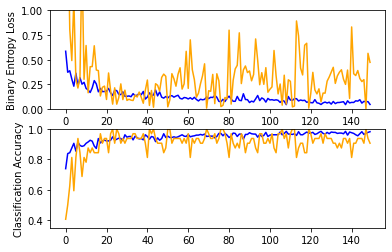

5/5 [==============================] - 5s 890ms/step - loss: 0.3383 - accuracy: 0.9139
> 91.391

Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Color Augmented Training
Epoch 1/150
14/14 [==============================] - 20s 1s/step - loss: 0.7629 - accuracy: 0.6950 - val_loss: 2.3986 - val_accuracy: 0.5312

Epoch 00001: val_accuracy improved from -inf to 0.53125, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/AugmentedSavedModels/model_6.h5
Epoch 2/150
14/14 [==============================] - 19s 1s/step - loss: 0.3004 - accuracy: 0.8694 - val_loss: 0.5230 - val_accuracy: 0.7188

Epoch 00002: val_accuracy improved from 0.53125 to 0.71875, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/AugmentedSavedModels/model_6.h5
Epoch 3/150
14/14 [==============================] - 18s 1s/step - loss: 0.3367 - accuracy: 0.8682 - val_loss: 0.4149 - val_accuracy: 0

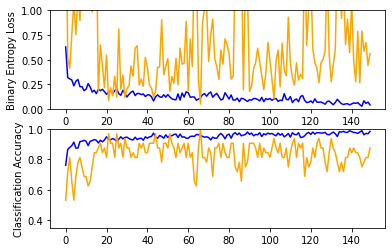

5/5 [==============================] - 5s 1s/step - loss: 0.6861 - accuracy: 0.8477
> 84.768

Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Color Augmented Training
Epoch 1/150
14/14 [==============================] - 22s 2s/step - loss: 0.7631 - accuracy: 0.6998 - val_loss: 0.7712 - val_accuracy: 0.6250

Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/AugmentedSavedModels/model_7.h5
Epoch 2/150
14/14 [==============================] - 20s 1s/step - loss: 0.3679 - accuracy: 0.8394 - val_loss: 0.7419 - val_accuracy: 0.5625

Epoch 00002: val_accuracy did not improve from 0.62500
Epoch 3/150
14/14 [==============================] - 20s 1s/step - loss: 0.3392 - accuracy: 0.8827 - val_loss: 0.2669 - val_accuracy: 0.9062

Epoch 00003: val_accuracy improved from 0.62500 to 0.90625, saving model to /content/drive/My Drive/C

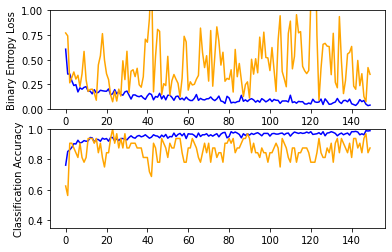

5/5 [==============================] - 5s 925ms/step - loss: 0.4551 - accuracy: 0.8344
> 83.444

Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Color Augmented Training
Epoch 1/150
14/14 [==============================] - 23s 2s/step - loss: 0.8954 - accuracy: 0.6825 - val_loss: 0.4799 - val_accuracy: 0.7500

Epoch 00001: val_accuracy improved from -inf to 0.75000, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/AugmentedSavedModels/model_8.h5
Epoch 2/150
14/14 [==============================] - 20s 1s/step - loss: 0.3553 - accuracy: 0.8476 - val_loss: 0.5177 - val_accuracy: 0.7188

Epoch 00002: val_accuracy did not improve from 0.75000
Epoch 3/150
14/14 [==============================] - 19s 1s/step - loss: 0.2553 - accuracy: 0.9023 - val_loss: 0.3703 - val_accuracy: 0.8125

Epoch 00003: val_accuracy improved from 0.75000 to 0.81250, saving model to /content/drive/My Driv

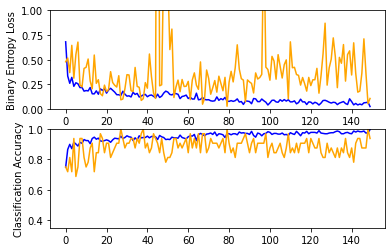

5/5 [==============================] - 5s 1s/step - loss: 0.3807 - accuracy: 0.8940
> 89.404

Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Color Augmented Training
Epoch 1/150
14/14 [==============================] - 21s 1s/step - loss: 0.7078 - accuracy: 0.6608 - val_loss: 5.0709 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/AugmentedSavedModels/model_9.h5
Epoch 2/150
14/14 [==============================] - 17s 1s/step - loss: 0.3962 - accuracy: 0.8497 - val_loss: 0.4138 - val_accuracy: 0.8438

Epoch 00002: val_accuracy improved from 0.50000 to 0.84375, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/AugmentedSavedModels/model_9.h5
Epoch 3/150
14/14 [==============================] - 19s 1s/step - loss: 0.3738 - accuracy: 0.8399 - val_loss: 0.3158 - val_accuracy: 0.93

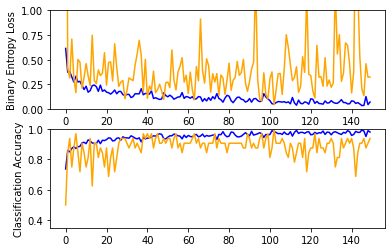

5/5 [==============================] - 5s 998ms/step - loss: 0.4275 - accuracy: 0.9073
> 90.728

Found 477 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
-------------Model: Color Augmented Training
Epoch 1/150
14/14 [==============================] - 21s 1s/step - loss: 0.8897 - accuracy: 0.6441 - val_loss: 0.7024 - val_accuracy: 0.5625

Epoch 00001: val_accuracy improved from -inf to 0.56250, saving model to /content/drive/My Drive/Colab/AIProject/SavedModels/AugmentedSavedModels/model_10.h5
Epoch 2/150
14/14 [==============================] - 19s 1s/step - loss: 0.3163 - accuracy: 0.8697 - val_loss: 2.2334 - val_accuracy: 0.4688

Epoch 00002: val_accuracy did not improve from 0.56250
Epoch 3/150
14/14 [==============================] - 19s 1s/step - loss: 0.3673 - accuracy: 0.8488 - val_loss: 2.6476 - val_accuracy: 0.3750

Epoch 00003: val_accuracy did not improve from 0.56250
Epoch 4/150
14/14 [=======================

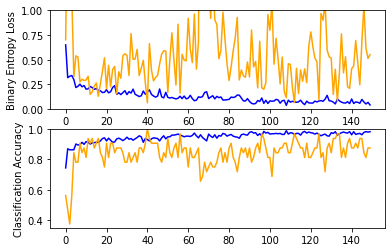

5/5 [==============================] - 5s 1s/step - loss: 0.3863 - accuracy: 0.9139
> 91.391


In [43]:
epochs = 150
numOfSplits = 10
kf = KFold(n_splits=numOfSplits)
augmentedAccuracy = []

fold_no = 0

# this is breaking up our training array instead of our actual data, we calculate indexes ourselves through the transfer file functions
for train_index, val_index in kf.split(trainArray):
  fold_no += 1

  # Make sure that all images are back in the training folder before we start our next fold
  TransferAllFiles(directory, validation_folder, training_folder, pothole_label, normal_label)

  TransferFiles(directory, training_folder, validation_folder, val_index, trainArray, trainLabelArray, pothole_label, normal_label)

  ######################## Image Data Generator ################################
  size = 100
  batchSize = 32

  train_datagen = ImageDataGenerator(
        rescale=1./255,
        
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        rotation_range=45
        )

  test_datagen = ImageDataGenerator(
        rescale=1./255)

  training_set = train_datagen.flow_from_directory('/content/drive/My Drive/Colab/AIProject/KCrossFoldFolder/augmented_training_set',
                                                  target_size=(imageSize,imageSize),
                                                  batch_size=batchSize,
                                                  shuffle = True,
                                                  color_mode='rgb',
                                                  class_mode='binary')

  val_set = test_datagen.flow_from_directory('/content/drive/My Drive/Colab/AIProject/KCrossFoldFolder/augmented_val_set',
                                              target_size=(imageSize,imageSize),
                                              batch_size=batchSize,
                                              shuffle = True,
                                              color_mode='rgb',
                                              class_mode='binary')

  test_set = test_datagen.flow_from_directory('/content/drive/My Drive/Colab/AIProject/KCrossFoldFolder/augmented_test_set',
                                              target_size=(imageSize,imageSize),
                                              batch_size=batchSize,
                                              shuffle = True,
                                              color_mode='rgb',
                                              class_mode='binary')
  
  ##############################################################################

  ############################ CHECK POINTS ####################################

  checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join("/content/drive/My Drive/Colab/AIProject/SavedModels/AugmentedSavedModels"+get_model_name(fold_no)), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')

  callbacks_list = [checkpoint]

  ##############################################################################

  ############################ MODEL TRAINING ##################################

  model = get2VGGblockModel()
  history = trainModel(model, "Color Augmented Training", training_set, val_set, epochs, callbacks_list)
  summarize_diagnostics(history)

  ##############################################################################

  augmentedAccuracy.append(evalModel(model, test_set))

  tf.keras.backend.clear_session()
  TransferAllFiles(directory, validation_folder, training_folder, pothole_label, normal_label)

# Augmented Results

In [1]:
for i in augmentedAccuracy:
  print(i)

print("The average of this list is: " + str(FindAverageOfList(augmnetedAccuracy)))
print("The standard deviation of this list is: " + np.std(augmentedAccuracy))

NameError: ignored

# Read In Augmented Nova Scotia Images + Determine Accuracy

In [12]:
imageSize = 100
batchSize = 32
numOfSplits = 10
nsAugmentedAccuracy = []
modelsPath = '/content/drive/My Drive/Colab/AIProject/SavedModels/AugmentedSavedModels'

test_datagen = ImageDataGenerator(
        rescale=1./255)
  
ns_set = test_datagen.flow_from_directory('/content/drive/My Drive/Colab/AIProject/NovaScotiaImages/AugmentedImages',
                                              target_size=(imageSize,imageSize),
                                              batch_size=batchSize,
                                              shuffle = True,
                                              color_mode='rgb',
                                              class_mode='binary')
  



for i in range(1, numOfSplits+1):
  model = load_model(os.path.join(modelsPath, str("model_" + str(i) +".h5")))
  nsAugmentedAccuracy.append(evalModel(model, ns_set))

print("The average accuracy on our Augmented Nova Scotia images is: " + str(FindAverageOfList(nsAugmentedAccuracy)))
print("The standard deviation of our accuracy on Augmented Nova Scotia images is: " + str(np.std(nsAugmentedAccuracy)))

Found 17 images belonging to 2 classes.
1/1 [==============================] - 5s 5s/step - loss: 0.8662 - accuracy: 0.7059
> 70.588
1/1 [==============================] - 5s 5s/step - loss: 0.7055 - accuracy: 0.7059
> 70.588
1/1 [==============================] - 5s 5s/step - loss: 0.4277 - accuracy: 0.8235
> 82.353
1/1 [==============================] - 5s 5s/step - loss: 0.5317 - accuracy: 0.8824
> 88.235
1/1 [==============================] - 5s 5s/step - loss: 1.3848 - accuracy: 0.6471
> 64.706
1/1 [==============================] - 5s 5s/step - loss: 1.5103 - accuracy: 0.6471
> 64.706
1/1 [==============================] - 5s 5s/step - loss: 0.5519 - accuracy: 0.8235
> 82.353
1/1 [==============================] - 5s 5s/step - loss: 1.0310 - accuracy: 0.7059
> 70.588
1/1 [==============================] - 5s 5s/step - loss: 2.2480 - accuracy: 0.5882
> 58.824
1/1 [==============================] - 5s 5s/step - loss: 0.4203 - accuracy: 0.8824
> 88.235
The average accuracy on our Au